In [1]:
import numpy as np
import sys, os

!pip install -U tensorly
!pip install opencv-python
import matplotlib.pyplot as plt
import tensorly as tl
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import cv2
from skimage.metrics import structural_similarity as ssim
from mpl_toolkits.mplot3d import axes3d
from scipy.misc import face
from scipy.ndimage import zoom
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from math import ceil


np.random.seed(42)

Requirement already up-to-date: tensorly in /home/dongmin/anaconda3/lib/python3.7/site-packages (0.4.5)


In [2]:
seed = 42
#sourcepath = "/media/data1/hsm/FACE_FORENSICS_C40/New_Preproc/"
sourcepath = "./OR"
real_data_dir = os.path.join(sourcepath, 'REAL')
fake_data_dir = os.path.join(sourcepath, 'FAKE', 'NeuralTextures')

real_filenames = np.array([os.path.join('REAL', f) for f in os.listdir(real_data_dir)])
fake_filenames = np.array([os.path.join('FAKE', 'NeuralTextures', f) for f in os.listdir(fake_data_dir)])

print("FROM DIR")
print("REAL: ", len(real_filenames))
print("FAKE: ", len(fake_filenames))
print("TOTAL: ", len(real_filenames) + len(fake_filenames))

FROM DIR
REAL:  10000
FAKE:  10000
TOTAL:  20000


In [3]:
# random sampling
'''
TOTAL_DATA_SIZE = 20000
real_filenames = np.random.choice(real_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()
fake_filenames = np.random.choice(fake_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()
'''

'\nTOTAL_DATA_SIZE = 20000\nreal_filenames = np.random.choice(real_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()\nfake_filenames = np.random.choice(fake_filenames, TOTAL_DATA_SIZE//2, replace = False).tolist()\n'

In [3]:
class ImageCreator():
    def __init__(self, sourcepath, savepath, real_filenames, fake_filenames):
        self.sourcepath = sourcepath
        self.savepath = savepath
        self.real_filenames = real_filenames
        self.fake_filenames = fake_filenames
        self.to_or = lambda x: x
        self.to_tk = lambda x: self.to_image(self.to_TK(self.to_tensor(x))) # to tk image
        self.to_cp = lambda x: self.to_image(self.to_CP(self.to_tensor(x))) # to cp image
        self.to_tk_diff = lambda x: self.to_image(self.get_diff_image(self.to_image(self.to_TK(self.to_tensor(x))), x))
        self.to_cp_diff = lambda x: self.to_image(self.get_diff_image(self.to_image(self.to_CP(self.to_tensor(x))), x))
        self.to_tk_add = lambda x: self.to_image(self.get_add_image(x, self.to_tk_diff(x)))
        self.to_tk_core = lambda x: self.to_gaussian_image(self.to_TK_core(self.to_tensor(x)))
        
    def create_image(self, subpath, preprocessing, real_path = "REAL", fake_path = "FAKE/NeuralTextures"):
        # get files here
        savepath = os.path.join(self.savepath, subpath)
        print("== Saving Data at {} ==".format(savepath))
        
        # assertions
        root_exists = os.path.exists(savepath)
        r = os.path.join(savepath, real_path)
        r_exists = os.path.exists(r)
        f = os.path.join(savepath, fake_path)
        f_exists = os.path.exists(f)
        
        print(savepath, ":", root_exists)
        print(r, ":", r_exists)
        print(f, ":", f_exists)
        assert(root_exists and r_exists and f_exists)
        
        r_hasfile = len(os.listdir(r))
        f_hasfile = len(os.listdir(f))        
        print("file count in real: ", r_hasfile)
        print("file count in fake: ", f_hasfile)

        #assert(not(r_hasfile or f_hasfile))
        print("== assertion done ==")

        # Create real files
        '''
        print("CREATING REAL FILES")
        cnt = 0
        total = len(self.real_filenames)
        for p in self.real_filenames:
            file = os.path.join(self.sourcepath, p)
            image = cv2.imread(file)
            created_image = preprocessing(image)###
            filename = os.path.join(savepath, p)
            cv2.imwrite(filename, created_image)
            if(cnt == 0):
                print(filename)
                plt.imshow(created_image)
                plt.show()
            print(".", end = "")
            cnt += 1
            if cnt % 100 == 0 :
                print("({}/{})".format(cnt, total))
        print("REAL FILE DONE")
        
        '''
        
        # Create fake files
        cnt = 0
        total = len(self.fake_filenames)
        for p in self.fake_filenames:
            file = os.path.join(self.sourcepath, p)
            image = cv2.imread(file)
            
            created_image = preprocessing(image)
            filename = os.path.join(savepath, p)
            cv2.imwrite(filename, created_image)
            if(cnt == 0):
                print(filename)
                plt.imshow(created_image)
                plt.show()
            print(".", end = "")
            cnt += 1
            if cnt % 100 == 0 :
                print("({}/{})".format(cnt, total))
        print("FAKE FILE DONE")
        
    def show_image(self, curpath, subpath, real_path = "REAL", fake_path = "FAKE/NeuralTextures", index = 0):
        # location
        real_loc = os.path.join(curpath, subpath, real_path)
        fake_loc = os.path.join(curpath, subpath, fake_path)
        
        real_filenames = np.array([os.path.join(real_path, f) for f in os.listdir(real_loc)])
        fake_filenames = np.array([os.path.join(fake_path, f) for f in os.listdir(fake_loc)])
        
        # file name
        real_file = os.path.join(curpath, subpath, real_filenames[index])
        fake_file = os.path.join(curpath, subpath, fake_filenames[index])

        # image
        real_image = cv2.cvtColor(cv2.imread(real_file), cv2.COLOR_BGR2RGB)
        fake_image = cv2.cvtColor(cv2.imread(fake_file), cv2.COLOR_BGR2RGB)
        
        # show
        fig = plt.figure()
        rows = 1
        cols = 2
        ax1 = fig.add_subplot(rows, cols, 1)
        ax1.imshow(real_image)
        ax1.set_title('REAL')
        ax1.axis("off")

        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(fake_image)
        ax2.set_title('FAKE')
        ax2.axis("off")

        plt.show()

    # original image to tensor  
    def to_tensor(self, image):
        return tl.tensor(zoom(image, (1, 1, 1)), dtype='float64')

    # tensor to image
    def to_image(self, tensor):
        im = tl.to_numpy(tensor)
        im -= im.min()
        im /= im.max()
        im *= 255
        return im.astype(np.uint8)
    
    def to_gaussian_image(self, tensor):
        im = tl.to_numpy(tensor)
        im_std = np.std(im)
        im_mean = np.mean(im)
        im -= im_mean
        im /= im_std
        im *= 255
        return im.astype(np.uint8)

    # get image difference
    def get_diff_image(self, image1, image2):
        output = lambda x: (x - np.min(x)) / np.max(x) # normalize
        x = np.abs(image1.astype(np.int)-image2.astype(np.int))
        return output(x)
    
    # get image addition
    def get_add_image(self, image1, image2):
        output = lambda x: (x - np.min(x)) / np.max(x) # normalize
        x = np.abs(image1.astype(np.int)+image2.astype(np.int))
        return output(x)

    # tensor decomposition using CP 
    def to_CP(self, tensor, r = 8):
        # Rank of the CP decomposition
        cp_rank = r
        # Perform the CP decomposition
        weights, factors = parafac(tensor, rank=cp_rank, init='random', tol=10e-6)
        # Reconstruct the image from the factors
        cp_reconstruction = tl.kruskal_to_tensor((weights, factors)) 
        return cp_reconstruction
    
    # tensor decomposition using TK
    def to_TK(self, tensor, r = [30, 30, 3]):
        # Rank of the Tucker decomposition
        tucker_rank = r
        random_state = 42
        # Tucker decomposition
        core, tucker_factors = tucker(tensor, ranks=tucker_rank, init='random', tol=10e-5, random_state=random_state)
        tucker_reconstruction = tl.tucker_to_tensor((core, tucker_factors))
        return tucker_reconstruction
    
    def to_TK_core(self, tensor, r = [128, 128, 3]):
        # Rank of the Tucker decomposition
        tucker_rank = r
        random_state = 42
        # Tucker decomposition
        core, tucker_factors = tucker(tensor, ranks=tucker_rank, init='random', tol=10e-5, random_state=random_state)
        return core

### Setups

In [4]:
imcr = ImageCreator(sourcepath, os.getcwd(), real_filenames, fake_filenames)

In [5]:
os.getcwd()

'/home/dongmin/Deepfake_with_tensor_decomposition'

In [6]:
real_filenames = real_filenames.tolist()

In [7]:
real_filenames

['REAL/989_frame490.jpg',
 'REAL/153_frame520.jpg',
 'REAL/26__podium_speech_happy_frame375.jpg',
 'REAL/476_frame150.jpg',
 'REAL/859_frame222.jpg',
 'REAL/290_frame180.jpg',
 'REAL/182_frame336.jpg',
 'REAL/13__walking_and_outside_surprised_frame185.jpg',
 'REAL/07__talking_angry_couch_frame960.jpg',
 'REAL/24__walking_outside_cafe_disgusted_frame200.jpg',
 'REAL/24__kitchen_still_frame195.jpg',
 'REAL/595_frame156.jpg',
 'REAL/544_frame192.jpg',
 'REAL/16__hugging_happy_frame180.jpg',
 'REAL/05__podium_speech_happy_frame315.jpg',
 'REAL/620_frame375.jpg',
 'REAL/031_frame220.jpg',
 'REAL/12__talking_against_wall_frame595.jpg',
 'REAL/114_frame1175.jpg',
 'REAL/814_frame420.jpg',
 'REAL/002_frame588.jpg',
 'REAL/17__exit_phone_room_frame155.jpg',
 'REAL/405_frame475.jpg',
 'REAL/04__talking_against_wall_frame750.jpg',
 'REAL/03__talking_against_wall_frame584.jpg',
 'REAL/17__walking_down_indoor_hall_disgust_frame165.jpg',
 'REAL/101_frame978.jpg',
 'REAL/909_frame72.jpg',
 'REAL/795_

In [8]:
fake_filenames = fake_filenames.tolist()

In [9]:
fake_filenames

['FAKE/NeuralTextures/050_059_frame445.jpg',
 'FAKE/NeuralTextures/920_811_frame345.jpg',
 'FAKE/NeuralTextures/720_672_frame474.jpg',
 'FAKE/NeuralTextures/990_008_frame135.jpg',
 'FAKE/NeuralTextures/984_967_frame75.jpg',
 'FAKE/NeuralTextures/089_065_frame80.jpg',
 'FAKE/NeuralTextures/790_014_frame222.jpg',
 'FAKE/NeuralTextures/644_657_frame385.jpg',
 'FAKE/NeuralTextures/476_400_frame35.jpg',
 'FAKE/NeuralTextures/841_639_frame462.jpg',
 'FAKE/NeuralTextures/629_618_frame260.jpg',
 'FAKE/NeuralTextures/912_927_frame420.jpg',
 'FAKE/NeuralTextures/952_882_frame78.jpg',
 'FAKE/NeuralTextures/901_902_frame0.jpg',
 'FAKE/NeuralTextures/050_059_frame235.jpg',
 'FAKE/NeuralTextures/423_421_frame290.jpg',
 'FAKE/NeuralTextures/962_929_frame312.jpg',
 'FAKE/NeuralTextures/735_774_frame24.jpg',
 'FAKE/NeuralTextures/443_514_frame20.jpg',
 'FAKE/NeuralTextures/020_344_frame325.jpg',
 'FAKE/NeuralTextures/141_161_frame294.jpg',
 'FAKE/NeuralTextures/588_556_frame215.jpg',
 'FAKE/NeuralTextu

### Original Image

== Saving Data at /home/dongmin/Deepfake_with_tensor_decomposition/OR ==
/home/dongmin/Deepfake_with_tensor_decomposition/OR : True
/home/dongmin/Deepfake_with_tensor_decomposition/OR/REAL : True
/home/dongmin/Deepfake_with_tensor_decomposition/OR/FAKE/NeuralTextures : True
file count in real:  0
file count in fake:  0
== assertion done ==
CREATING REAL FILES
/home/dongmin/Deepfake_with_tensor_decomposition/OR/REAL/20__walking_down_street_outside_angry_frame115.jpg


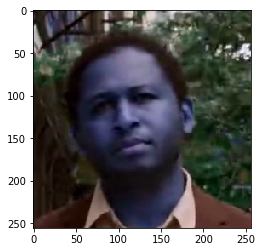

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

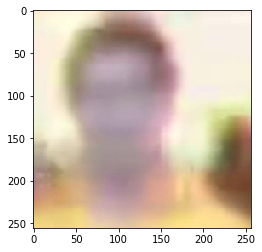

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

In [8]:
imcr.create_image('OR', imcr.to_or)

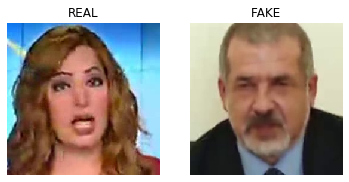

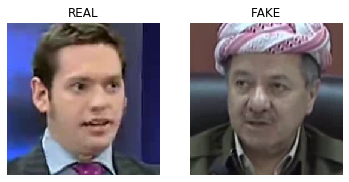

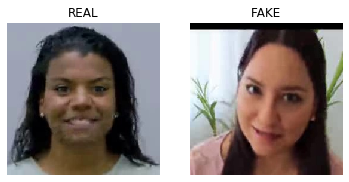

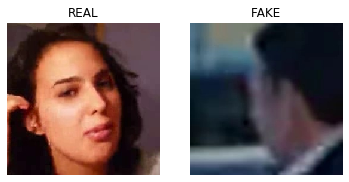

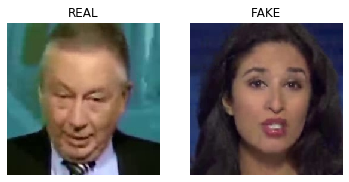

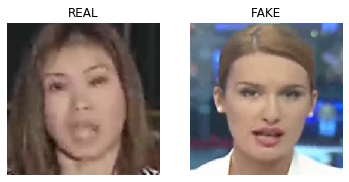

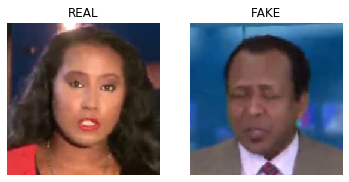

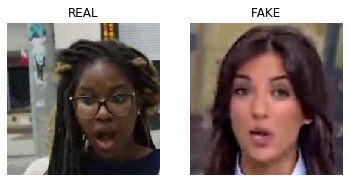

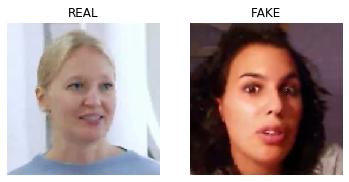

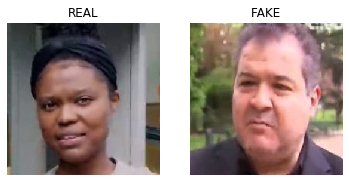

In [9]:
for i in range(10):
    imcr.show_image(os.getcwd(), 'OR', index = i)

### TK Images Experiments 

In [9]:
print(imcr)

### REAL

In [10]:
testimg_REAL = cv2.imread("./OR/REAL/000_frame100.jpg")

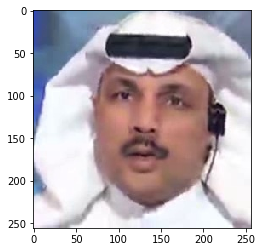

In [11]:
plt.imshow(cv2.cvtColor(testimg_REAL, cv2.COLOR_BGR2RGB))

In [12]:
core, factors = imcr.to_TK_core(imcr.to_tensor(testimg_REAL), r = [128, 128, 3])

In [13]:
np.shape(core)

(128, 128, 3)

(256, 128)
minmax norm
[[ 97 158 114 ... 141 117  97]
 [ 97 160 112 ... 124 125 119]
 [ 97 162 111 ... 113 116 109]
 ...
 [ 84 166 134 ...  99 113 123]
 [ 84 166 134 ... 115 116 115]
 [ 84 166 134 ... 137 111 135]]
gaussian norm
[[ 45  53 184 ... 168 215  38]
 [ 43  70 174 ...  20  23 236]
 [ 40  88 164 ... 181 206 143]
 ...
 [189 124 104 ...  58 176  13]
 [188 123 106 ... 197 201 197]
 [188 123 107 ... 135 166 111]]


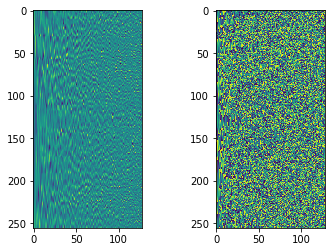

In [14]:
print(np.shape(factors[0]))
print("minmax norm")
print(imcr.to_image(factors[0]))

print("gaussian norm")
print(imcr.to_gaussian_image(factors[0]))

plt.figure()
plt.subplot(121)
plt.imshow(imcr.to_image(factors[0]))
plt.subplot(122)
plt.imshow(imcr.to_gaussian_image(factors[0]))

(256, 128)
minmax norm
[[ 88 123 119 ... 130 113 110]
 [ 88 125 118 ... 121 131 131]
 [ 88 127 117 ...  67  70  79]
 ...
 [ 80 134  94 ... 140  79 112]
 [ 80 134  94 ... 126 101 103]
 [ 80 134  95 ...  80 152 134]]
gaussian norm
[[ 39 117  75 ... 184  17 249]
 [ 35 135  69 ...  98 199 198]
 [ 30 157  60 ...  91 115 207]
 ...
 [209 224  94 ...  28 207  12]
 [210 221  95 ... 150 162 182]
 [209 221 101 ... 212 145 226]]


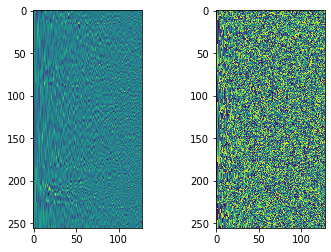

In [15]:
print(np.shape(factors[1]))
print("minmax norm")
print(imcr.to_image(factors[1]))

print("gaussian norm")
print(imcr.to_gaussian_image(factors[1]))

plt.figure()
plt.subplot(121)
plt.imshow(imcr.to_image(factors[1]))
plt.subplot(122)
plt.imshow(imcr.to_gaussian_image(factors[1]))

(3, 3)
minmax norm
[[ 41 255 237]
 [ 44 172   0]
 [ 39   8 189]]
gaussian norm
[[ 75 127  80]
 [ 84 166 223]
 [ 71 245 211]]


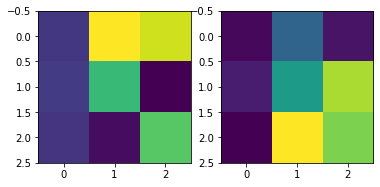

In [17]:
print(np.shape(factors[2]))
print("minmax norm")
print(imcr.to_image(factors[2]))

print("gaussian norm")
print(imcr.to_gaussian_image(factors[2]))

plt.figure()
plt.subplot(121)
plt.imshow(imcr.to_image(factors[2]))
plt.subplot(122)
plt.imshow(imcr.to_gaussian_image(factors[2]))

(128, 128, 3)
minmax norm
[[[  0 212 213]
  [213 202 214]
  [212 212 212]
  ...
  [212 212 212]
  [212 212 212]
  [212 212 212]]

 [[213 205 212]
  [255 208 214]
  [210 212 213]
  ...
  [212 212 212]
  [212 212 212]
  [212 212 212]]

 [[213 208 213]
  [210 209 213]
  [183 212 211]
  ...
  [212 212 212]
  [212 212 212]
  [212 212 212]]

 ...

 [[212 212 212]
  [212 212 212]
  [212 212 212]
  ...
  [212 212 212]
  [212 212 212]
  [212 212 212]]

 [[212 212 212]
  [212 212 212]
  [212 212 212]
  ...
  [212 212 212]
  [212 212 212]
  [212 212 212]]

 [[212 212 212]
  [212 212 212]
  [212 212 212]
  ...
  [212 212 212]
  [212 212 212]
  [212 212 212]]]
gaussian norm
[[[148 111 191]
  [ 87 134  27]
  [  4 161   9]
  ...
  [  1   0   3]
  [  1   0   2]
  [  1   0   4]]

 [[ 88 120 246]
  [204  92   5]
  [ 23 156  23]
  ...
  [  0   1   2]
  [  0 255 255]
  [  0   0   1]]

 [[ 53  64  30]
  [ 91 122 159]
  [ 72  88  24]
  ...
  [  1   2   1]
  [  1   1 255]
  [  1   1   0]]

 ...

 [[  1   0  

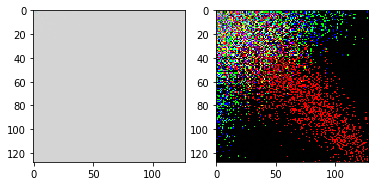

In [18]:
print(np.shape(core))
print("minmax norm")
print(imcr.to_image(core))

print("gaussian norm")
print(imcr.to_gaussian_image(core))

plt.figure()
plt.subplot(121)
plt.imshow(imcr.to_image(core))
plt.subplot(122)
plt.imshow(imcr.to_gaussian_image(core))

### FAKE

In [19]:
testimg_FAKE = cv2.imread("./OR/FAKE/NeuralTextures/916_783_frame150.jpg")
print(testimg_FAKE)

[[[228 159  86]
  [229 160  87]
  [231 162  89]
  ...
  [247 182 127]
  [247 182 127]
  [247 182 127]]

 [[228 159  86]
  [229 160  87]
  [231 162  89]
  ...
  [247 182 127]
  [247 182 127]
  [247 182 127]]

 [[228 159  86]
  [229 160  87]
  [231 162  89]
  ...
  [247 182 127]
  [247 182 127]
  [247 182 127]]

 ...

 [[235 232 234]
  [235 232 234]
  [235 232 234]
  ...
  [237 234 236]
  [237 234 236]
  [237 234 236]]

 [[235 232 234]
  [235 232 234]
  [235 232 234]
  ...
  [237 234 236]
  [237 234 236]
  [237 234 236]]

 [[235 232 234]
  [235 232 234]
  [235 232 234]
  ...
  [237 234 236]
  [237 234 236]
  [237 234 236]]]


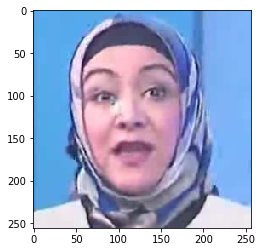

In [20]:
plt.imshow(cv2.cvtColor(testimg_FAKE, cv2.COLOR_BGR2RGB))

In [26]:
core, factors = imcr.to_TK_core(imcr.to_tensor(testimg_FAKE), r = [128, 128, 3])
np.shape(core)

(128, 128, 3)

(256, 128)
minmax norm
[[156 121 171 ...  82 153 110]
 [156 121 170 ... 118 123 110]
 [156 122 170 ... 169  91 129]
 ...
 [157  69  92 ... 108 142 137]
 [157  70  91 ...  98 127 150]
 [157  71  91 ... 161 122 109]]
gaussian norm
[[255 162 148 ...  30 227  57]
 [  0 167 142 ... 132 180  53]
 [  0 170 137 ... 131 117 243]
 ...
 [  9 156 132 ...  33 115  66]
 [ 10 168 124 ... 193 223 197]
 [ 12 183 118 ...  51 176  48]]


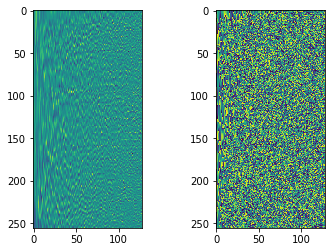

In [27]:
print(np.shape(factors[0]))
print("minmax norm")
print(imcr.to_image(factors[0]))

print("gaussian norm")
print(imcr.to_gaussian_image(factors[0]))

plt.figure()
plt.subplot(121)
plt.imshow(imcr.to_image(factors[0]))
plt.subplot(122)
plt.imshow(imcr.to_gaussian_image(factors[0]))

(256, 128)
minmax norm
[[133 137 109 ...  83 128 129]
 [133 137 109 ...  88 110 105]
 [134 137 109 ...  93 119  97]
 ...
 [138 131 111 ... 179 110  84]
 [138 131 111 ... 189 116  72]
 [138 131 111 ... 192 119  64]]
gaussian norm
[[244  29 239 ... 220 194 203]
 [247  30 243 ...  15 250 197]
 [251  31 247 ...  75  96 109]
 ...
 [ 38 217  12 ... 228 253 229]
 [ 37 218  11 ...  71  62 104]
 [ 37 218  11 ... 112  96  19]]


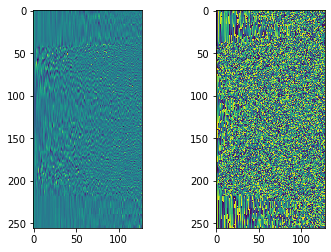

In [28]:
print(np.shape(factors[1]))
print("minmax norm")
print(imcr.to_image(factors[1]))

print("gaussian norm")
print(imcr.to_gaussian_image(factors[1]))

plt.figure()
plt.subplot(121)
plt.imshow(imcr.to_image(factors[1]))
plt.subplot(122)
plt.imshow(imcr.to_gaussian_image(factors[1]))

(3, 3)
minmax norm
[[ 29 255 248]
 [ 55 173   0]
 [ 63   0 197]]
gaussian norm
[[ 39 109  92]
 [105 153 220]
 [127 218 216]]


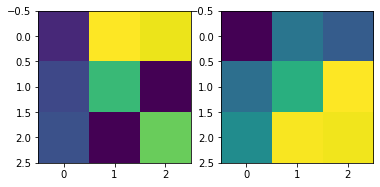

In [29]:
print(np.shape(factors[2]))
print("minmax norm")
print(imcr.to_image(factors[2]))

print("gaussian norm")
print(imcr.to_gaussian_image(factors[2]))

plt.figure()
plt.subplot(121)
plt.imshow(imcr.to_image(factors[2]))
plt.subplot(122)
plt.imshow(imcr.to_gaussian_image(factors[2]))

(128, 128, 3)
minmax norm
[[[  0 228 226]
  [226 255 223]
  [226 227 227]
  ...
  [226 226 226]
  [226 226 226]
  [226 226 226]]

 [[228 226 228]
  [250 241 227]
  [224 224 225]
  ...
  [226 226 226]
  [226 226 226]
  [226 226 226]]

 [[226 238 227]
  [224 225 226]
  [210 224 224]
  ...
  [226 226 226]
  [226 226 226]
  [226 226 226]]

 ...

 [[226 226 226]
  [226 226 226]
  [226 226 226]
  ...
  [226 226 226]
  [226 226 226]
  [226 226 226]]

 [[226 226 226]
  [226 226 226]
  [226 226 226]
  ...
  [226 226 226]
  [226 226 226]
  [226 226 226]]

 [[226 226 226]
  [226 226 226]
  [226 226 226]
  ...
  [226 226 226]
  [226 226 226]
  [226 226 226]]]
gaussian norm
[[[ 53 145 179]
  [111  42 222]
  [  9  87 216]
  ...
  [  0   1   0]
  [  0   0   0]
  [  0   1   3]]

 [[248 176 136]
  [ 38 236 104]
  [170  98 222]
  ...
  [  1 254   6]
  [  1   0   0]
  [  1   0   0]]

 [[ 19   8 155]
  [158 193  12]
  [ 79 125 166]
  ...
  [  1   1   2]
  [  0   1   1]
  [  1   0   0]]

 ...

 [[  0   1  

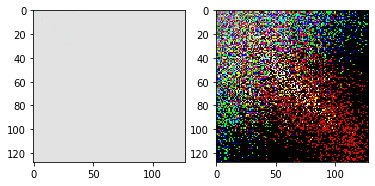

In [30]:
print(np.shape(core))
print("minmax norm")
print(imcr.to_image(core))

print("gaussian norm")
print(imcr.to_gaussian_image(core))

plt.figure()
plt.subplot(121)
plt.imshow(imcr.to_image(core))
plt.subplot(122)
plt.imshow(imcr.to_gaussian_image(core))

== Saving Data at /home/dongmin/TK ==
/home/dongmin/TK : True
/home/dongmin/TK/REAL : True
/home/dongmin/TK/FAKE/NeuralTextures : True
file count in real:  0
file count in fake:  0
== assertion done ==
CREATING REAL FILES
/home/dongmin/TK/REAL/20__walking_down_street_outside_angry_frame115.jpg


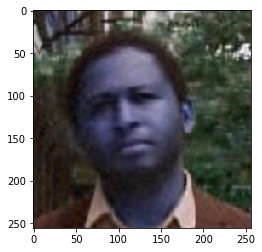

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

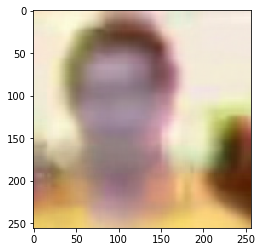

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

In [9]:
imcr.create_image('TK', imcr.to_tk)

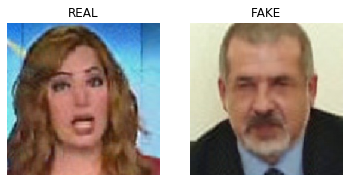

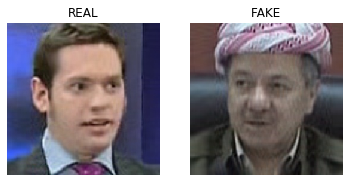

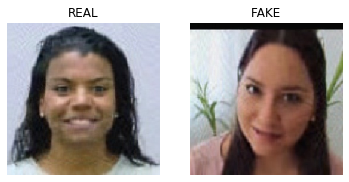

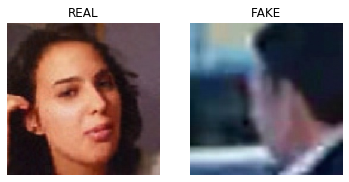

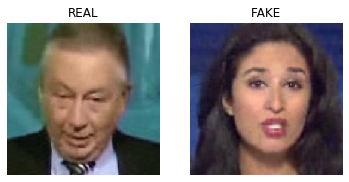

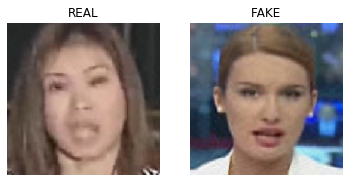

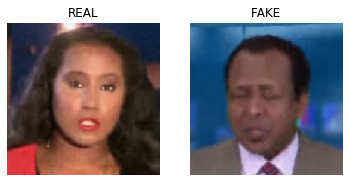

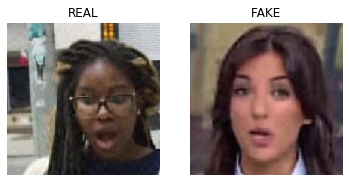

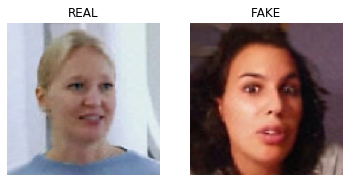

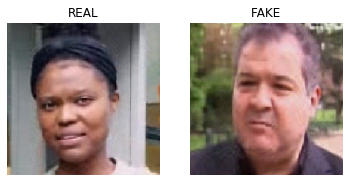

In [10]:
for i in range(10):
    imcr.show_image(os.getcwd(), 'TK', index = i)

### TK Diff Images

== Saving Data at /home/dongmin/TK_diff ==
/home/dongmin/TK_diff : True
/home/dongmin/TK_diff/REAL : True
/home/dongmin/TK_diff/FAKE/NeuralTextures : True
file count in real:  0
file count in fake:  0
== assertion done ==
CREATING REAL FILES
/home/dongmin/TK_diff/REAL/20__walking_down_street_outside_angry_frame115.jpg


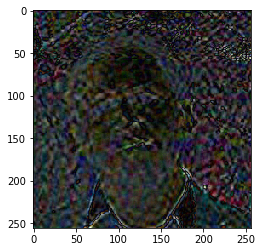

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

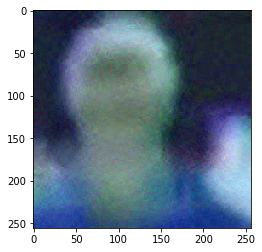

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

In [8]:
imcr.create_image('TK_diff', imcr.to_tk_diff)

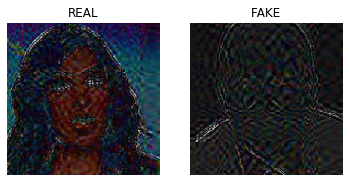

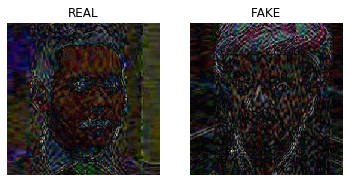

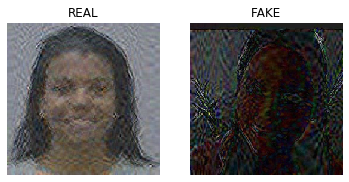

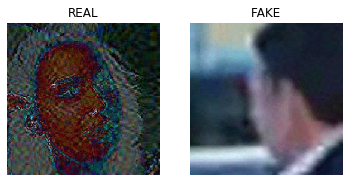

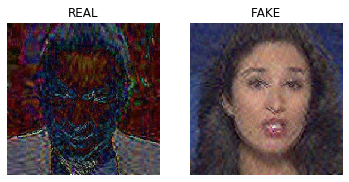

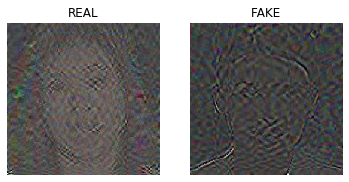

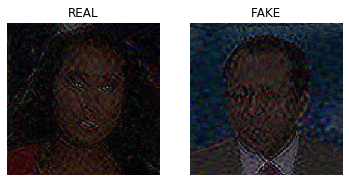

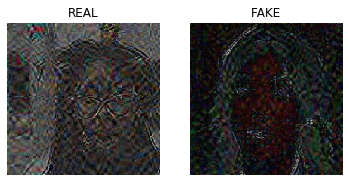

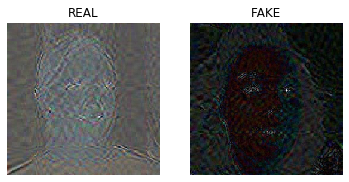

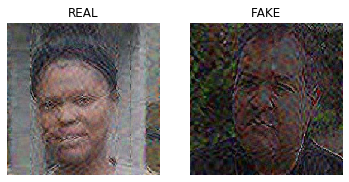

In [9]:
for i in range(10):
    imcr.show_image(os.getcwd(), 'TK_diff', index = i)

### TK Core

== Saving Data at /home/dongmin/Deepfake_with_tensor_decomposition/TK_core ==
/home/dongmin/Deepfake_with_tensor_decomposition/TK_core : True
/home/dongmin/Deepfake_with_tensor_decomposition/TK_core/REAL : True
/home/dongmin/Deepfake_with_tensor_decomposition/TK_core/FAKE/NeuralTextures : True
file count in real:  10000
file count in fake:  0
== assertion done ==
/home/dongmin/Deepfake_with_tensor_decomposition/TK_core/FAKE/NeuralTextures/050_059_frame445.jpg


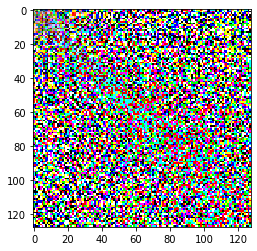

....................................................................................................(100/10000)
....................................................................................................(200/10000)
....................................................................................................(300/10000)
....................................................................................................(400/10000)
....................................................................................................(500/10000)
....................................................................................................(600/10000)
....................................................................................................(700/10000)
....................................................................................................(800/10000)
....................................................................................................(900

In [11]:
imcr.create_image("TK_core", imcr.to_tk_core)